# **Deteksi dan Klasifikasi Penyakit pada Tanaman Menggunakan Algoritma CNN**


**Kelompok : 3**

**Mitra : Hactiv8**

Topik project ini adalah deteksi dan klasifikasi penyakit tanaman
dengan menggunakan dataset PlantVillage. Tujuan dari proyek ini adalah mengembangkan model
yang mampu mengidentifikasi penyakit pada daun tanaman dengan tingkat akurasi yang tinggi.
Metode evaluasi yang digunakan adalah akurasi.

## Import Libraries

Pada tahap ini kita akan mengimport beberapa libraries untuk mengambil beberapa function dan class yang nantinya akan digunakan dalam project ini

In [1]:
# Import necessary libraries
!pip install kaggle
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from PIL import Image
import cv2
from wordcloud import WordCloud

## Data Loading & Cleaning

Memuat dataset PlantVillage dari Kaggle, mengekstraknya, dan membaca semua gambar serta labelnya ke dalam sebuah DataFrame pandas.

In [2]:
# Step to upload kaggle.json
from google.colab import files
files.upload()

# Create kaggle directory and move kaggle.json there
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Verify Kaggle setup
!kaggle datasets list

# Download and unzip the PlantVillage dataset
!kaggle datasets download -d emmarex/plantdisease
!unzip plantdisease.zip -d plantvillage

Streaming output truncated to the last 5000 lines.
  inflating: plantvillage/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08c033bd-fbc3-445a-88d1-1863070e52ce___YLCV_GCREC 2872.JPG  
  inflating: plantvillage/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08dd176c-e9d9-4746-92c3-fa8dc9074347___UF.GRC_YLCV_Lab 03057.JPG  
  inflating: plantvillage/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08f78a80-46f5-45a6-937c-4d05d61c08c2___UF.GRC_YLCV_Lab 01895.JPG  
  inflating: plantvillage/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0903aa95-6e8a-4abd-a003-126fcd9a5493___YLCV_GCREC 2806.JPG  
  inflating: plantvillage/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0911d416-d73d-4c2a-8e45-207a7ceb7c9a___YLCV_GCREC 2773.JPG  
  inflating: plantvillage/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/09188838-cc89-4925-94c5-d9563c4cb4bf___UF.GRC_YLCV_Lab 02974.JPG  
  inflating: plantvillage

 Mengatur path ke direktori dataset yang telah diekstrak dan mencetak daftar kategori yang ada dalam dataset tersebut

In [3]:
# metaruh path ke dataset directory
base_dir =  'plantvillage/PlantVillage'
categories = os.listdir(base_dir)
print(f"Categories: {categories}")

Categories: ['Potato___healthy', 'Pepper__bell___Bacterial_spot', 'Tomato_Early_blight', 'Tomato__Target_Spot', 'Tomato_healthy', 'Tomato_Septoria_leaf_spot', 'Tomato_Bacterial_spot', 'Potato___Late_blight', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato_Leaf_Mold', 'Tomato_Late_blight', 'Tomato__Tomato_mosaic_virus', 'Tomato_Spider_mites_Two_spotted_spider_mite']


Lalu kita akan membuat function yang bertujuan untuk menyiapkan dataset dalam bentuk yang mudah digunakan untuk analisis lebih lanjut dan pemodelan, yaitu dengan memetakan setiap gambar ke kategori atau label yang sesuai.

In [4]:
# Data Cleaning
data = []
labels = []
for category in categories:
    category_path = os.path.join(base_dir, category)
    for img in os.listdir(category_path):
        img_path = os.path.join(category_path, img)
        data.append(img_path)
        labels.append(category)

In [5]:
# Create DataFrame
df = pd.DataFrame({
    'image_path': data,
    'label': labels
})

Memeriksa apakah ada data yang hilang dalam DataFrame df dan menghitung total jumlah gambar dalam dataset.Langkah ini penting untuk memastikan integritas data sebelum melanjutkan ke tahap pemrosesan dan pelatihan model.


In [6]:
# cek data yang hilang
print(df.isnull().sum())
print(f"Total images: {len(df)}")

image_path    0
label         0
dtype: int64
Total images: 20639


In [7]:
# Verifikasi distribusi kategori
print(df['label'].value_counts())

label
Tomato__Tomato_YellowLeaf__Curl_Virus          3209
Tomato_Bacterial_spot                          2127
Tomato_Late_blight                             1909
Tomato_Septoria_leaf_spot                      1771
Tomato_Spider_mites_Two_spotted_spider_mite    1676
Tomato_healthy                                 1591
Pepper__bell___healthy                         1478
Tomato__Target_Spot                            1404
Potato___Early_blight                          1000
Tomato_Early_blight                            1000
Potato___Late_blight                           1000
Pepper__bell___Bacterial_spot                   997
Tomato_Leaf_Mold                                952
Tomato__Tomato_mosaic_virus                     373
Potato___healthy                                152
Name: count, dtype: int64


## EDA

Membuat visualisasi distribusi label dalam dataset PlantVillage menggunakan seaborn dan matplotlib. Pertama, sebuah figure dengan ukuran 10x5 inci dibuat. Lalu, menggunakan seaborn's countplot, distribusi dari setiap label diplot dalam bentuk bar chart, dengan urutan berdasarkan jumlah kemunculan masing-masing label secara menurun. Visualisasi ini membantu memahami bagaimana data tersebar di antara berbagai kategori dalam dataset.

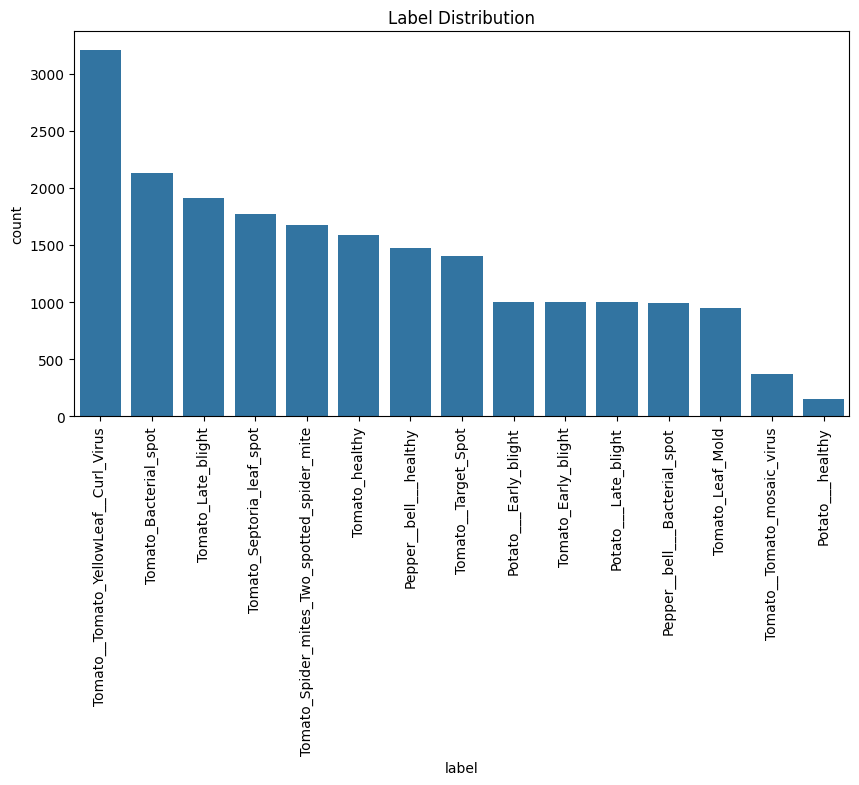

In [8]:
# Visualisasi distribusi label
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='label', order=df['label'].value_counts().index)
plt.xticks(rotation=90)
plt.title('Label Distribution')
plt.show()

Membuat 2 function untuk memilih satu gambar unik dari setiap kategori dan menampilkannya, memberikan visualisasi representatif dari setiap kategori penyakit tanaman dalam dataset.Fungsi *get_unique_images* memilih satu gambar dari setiap kategori dalam DataFrame *df* dengan mengelompokkan data berdasarkan label dan mengambil gambar pertama dari setiap kelompok. Fungsi *plot_images* kemudian digunakan untuk menampilkan gambar-gambar tersebut.

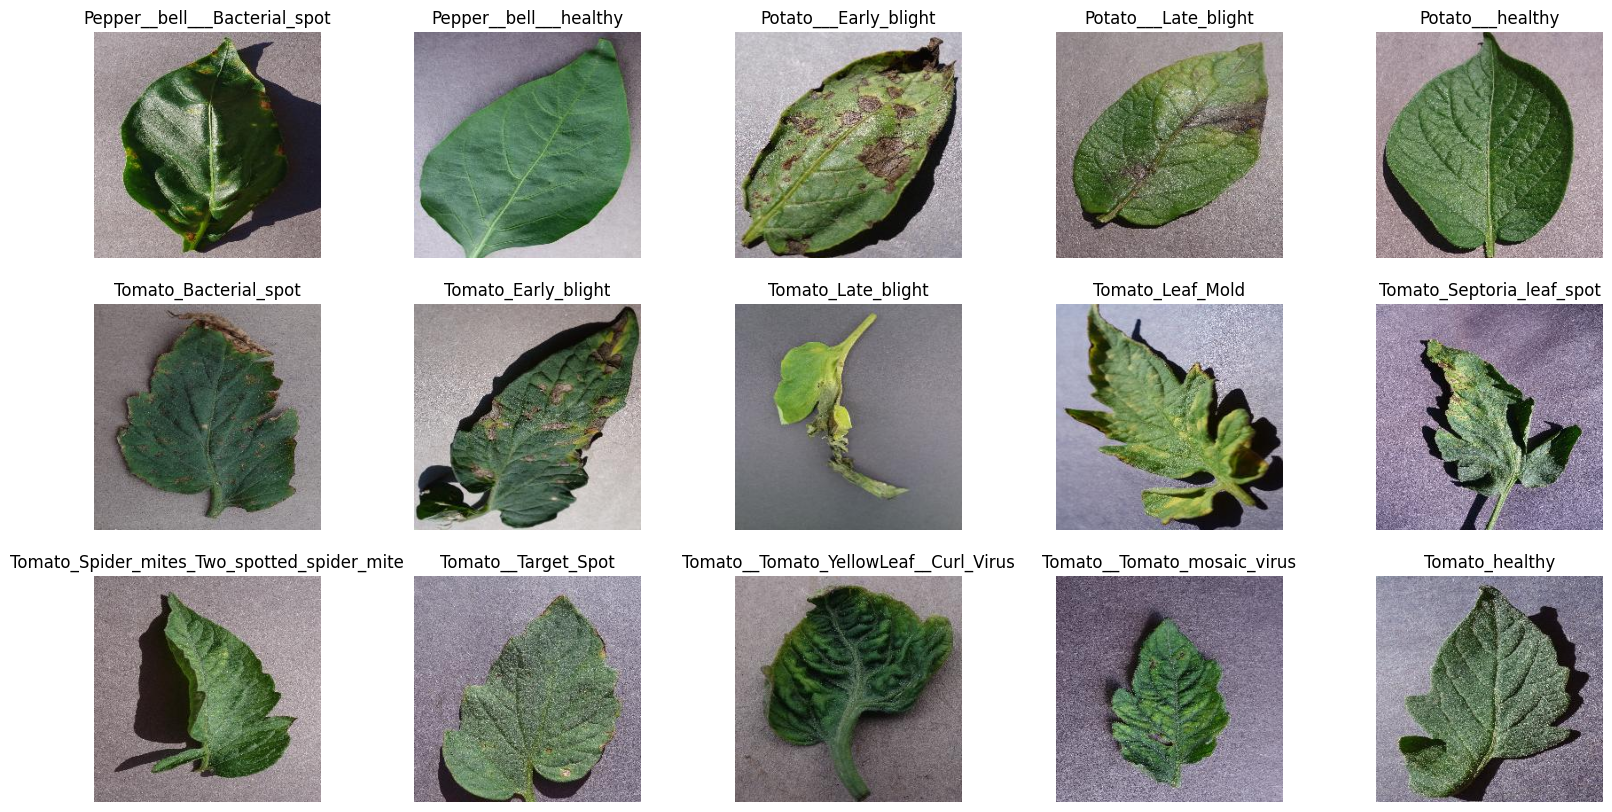

In [9]:
# Fungsi untuk memilih satu gambar dari setiap kategori
def get_unique_images(df):
    unique_images = df.groupby('label').first().reset_index()
    return unique_images['image_path'].values, unique_images['label'].values

# Fungsi untuk menampilkan gambar
def plot_images(images, labels, num=10):
    plt.figure(figsize=(20, 10))
    for i in range(num):
        img = cv2.imread(images[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(3, num//3 + num % 3, i+1)
        plt.imshow(img)
        plt.title(labels[i])
        plt.axis('off')
    plt.show()

# Pilih satu gambar dari setiap kategori
unique_images, unique_labels = get_unique_images(df)

# Visualisasi gambar-gambar unik dari setiap kategori
plot_images(unique_images, unique_labels, num=len(unique_images))


Memvisualisasikan gambar-gambar tersebut dalam bentuk yang dibalik secara vertikal, memberikan representasi yang berbeda dari setiap kategori dalam dataset.

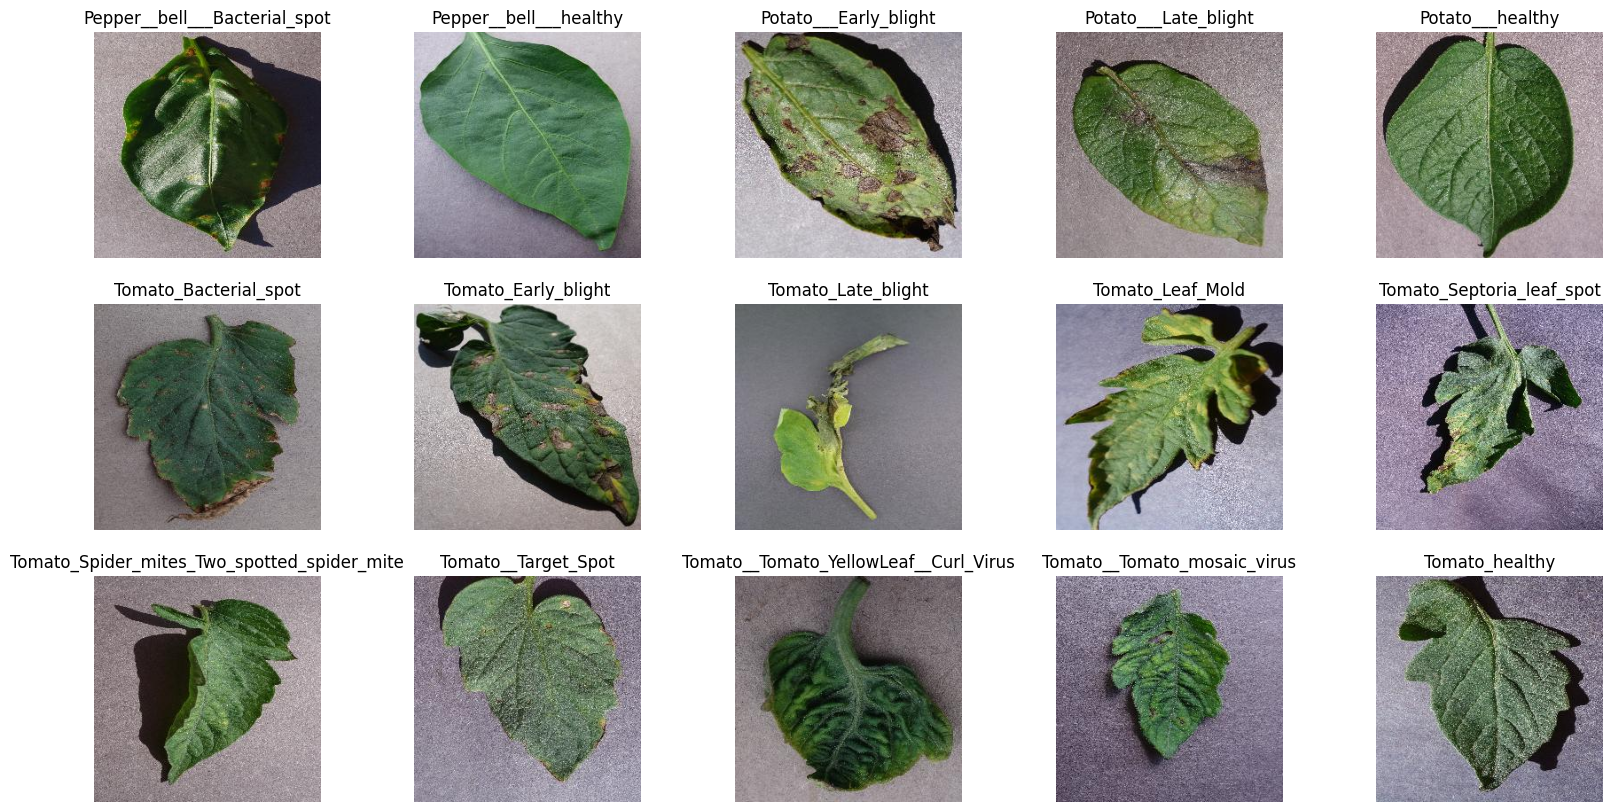

In [10]:
# Fungsi untuk memilih satu gambar dari setiap kategori
def get_unique_images(df):
    unique_images = df.groupby('label').first().reset_index()
    return unique_images['image_path'].values, unique_images['label'].values

# Fungsi untuk menampilkan gambar dengan tampilan flip
def plot_images_flip(images, labels, num=10):
    plt.figure(figsize=(20, 10))
    for i in range(num):
        img = cv2.imread(images[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        flipped_img = cv2.flip(img, 0)  # flip gambar vertical
        plt.subplot(3, num//3 + num % 3, i+1)
        plt.imshow(flipped_img)
        plt.title(labels[i])
        plt.axis('off')
    plt.show()

# Pilih satu gambar dari setiap kategori
unique_images, unique_labels = get_unique_images(df)

# Visualisasi gambar-gambar unik dari setiap kategori dengan tampilan flip
plot_images_flip(unique_images, unique_labels, num=len(unique_images))

## Feature Engineering

Membagi dataset yang telah difilter menjadi tiga set: training, validation, dan testing, dengan rasio 64%, 16%, dan 20%, menggunakan stratifikasi berdasarkan label untuk menjaga distribusi kategori yang seimbang.Selanjutnya, data augmentation diterapkan pada set training menggunakan ImageDataGenerator untuk memperkaya data dengan transformasi seperti rescaling, shear, zoom, flipping horizontal, rotasi, dan pergeseran gambar.Langkah ini penting untuk mempersiapkan data sebelum melatih model deep learning, memastikan variasi yang cukup dalam set training dan evaluasi yang tepat pada set validation dan testing.

In [11]:
# Split dataset kedalam training, validation, and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['label'], random_state=42)

# menampilkan jumlah sampel di setiap set
print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Testing samples: {len(test_df)}")

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow dari dataframe untuk train, validation and test sets
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='image_path',
    y_col='label',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col='image_path',
    y_col='label',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='image_path',
    y_col='label',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Training samples: 13208
Validation samples: 3303
Testing samples: 4128
Found 13207 validated image filenames belonging to 15 classes.
Found 3303 validated image filenames belonging to 15 classes.
Found 4128 validated image filenames belonging to 15 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  warnings.warn(


## Model Architecture Definition

Mendefinisikan arsitektur model Convolutional Neural Network (CNN) menggunakan framework Keras. Arsitektur model terdiri dari beberapa lapisan konvolusi (Conv2D) dan lapisan pooling (MaxPooling2D) untuk mengekstrak fitur dari gambar. Lapisan-lapisan tersebut diikuti oleh lapisan Flatten untuk meratakan output menjadi vektor satu dimensi, yang kemudian disambungkan ke lapisan Dense (fully connected) untuk proses klasifikasi. Lapisan Dropout diterapkan untuk mengurangi overfitting dengan secara acak menonaktifkan sebagian unit selama pelatihan. Akhirnya, lapisan output menggunakan aktivasi softmax untuk menghasilkan probabilitas kelas untuk setiap gambar. Model dikompilasi dengan pengoptimum Adam dan fungsi loss categorical crossentropy untuk masalah klasifikasi multi-kelas, serta metrik akurasi untuk mengukur kinerja model. Model summary juga dicetak untuk memberikan gambaran tentang jumlah parameter dan struktur keseluruhan model yang telah dibangun.

In [12]:
# Mendefinisikan model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(categories), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 128)       0

## Model Training & Evaluation

menginisiasi proses pelatihan model dengan memanggil metode fit pada objek model. Proses pelatihan menggunakan generator data pelatihan train_generator sebagai input, sementara generator data validasi val_generator digunakan untuk memvalidasi kinerja model setiap epoch. Pelatihan dilakukan selama 20 epoch, di mana model akan mempelajari pola-pola yang ada dalam dataset pelatihan dan menyesuaikan bobotnya secara iteratif untuk meningkatkan akurasi pada data validasi. Hasil dari pelatihan, termasuk loss dan metrik akurasi, akan disimpan dalam objek history untuk dianalisis lebih lanjut setelah pelatihan selesai.

In [13]:
# Model Training
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20
)

Epoch 1/20
413/413 [==============================] - 99s 224ms/step - loss: 1.9699 - accuracy: 0.3631 - val_loss: 1.8673 - val_accuracy: 0.3981
Epoch 2/20
413/413 [==============================] - 74s 178ms/step - loss: 1.4034 - accuracy: 0.5394 - val_loss: 0.9340 - val_accuracy: 0.6757
Epoch 3/20
413/413 [==============================] - 75s 183ms/step - loss: 1.1953 - accuracy: 0.6010 - val_loss: 0.9043 - val_accuracy: 0.6833
Epoch 4/20
413/413 [==============================] - 73s 177ms/step - loss: 1.0688 - accuracy: 0.6394 - val_loss: 1.0956 - val_accuracy: 0.6527
Epoch 5/20
413/413 [==============================] - 71s 173ms/step - loss: 1.0037 - accuracy: 0.6617 - val_loss: 0.9007 - val_accuracy: 0.6966
Epoch 6/20
413/413 [==============================] - 73s 177ms/step - loss: 0.9090 - accuracy: 0.6883 - val_loss: 0.6830 - val_accuracy: 0.7578
Epoch 7/20
413/413 [==============================] - 72s 174ms/step - loss: 0.8422 - accuracy: 0.7155 - val_loss: 0.5523 - val_ac

Mengevaluasi kinerja model setelah pelatihan selesai. Pertama, grafik akurasi dan loss dari data pelatihan dan validasi selama setiap epoch ditampilkan menggunakan matplotlib. Grafik tersebut memberikan pemahaman visual tentang bagaimana model berkembang selama pelatihan, dengan harapan akurasi meningkat dan loss menurun seiring berjalannya waktu. Setelah menampilkan grafik, model dievaluasi menggunakan data pengujian (test_generator). Metrik loss dan akurasi pada data pengujian dicetak, memberikan gambaran tentang seberapa baik model dapat menggeneralisasi pada data baru.

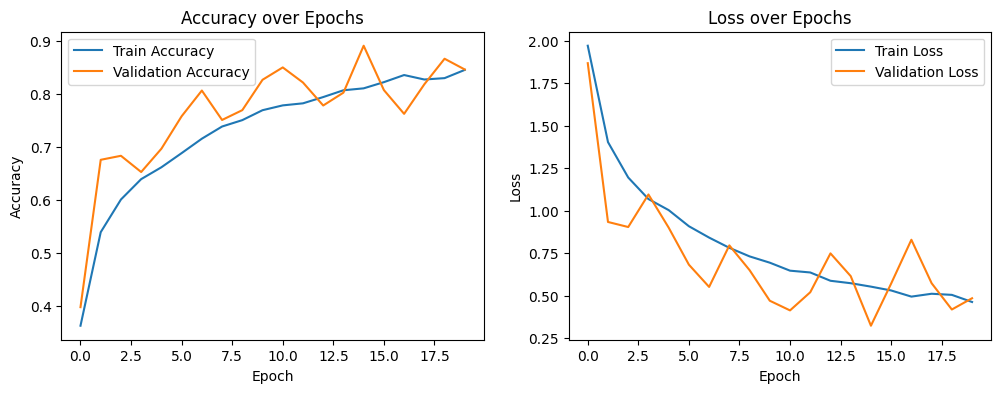

129/129 [==============================] - 5s 40ms/step - loss: 0.5508 - accuracy: 0.8387
Test Accuracy: 83.87%


In [14]:
# Plot accuracy and loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.show()

# Model Evaluation
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

 Selanjutnya, laporan klasifikasi yang mencakup metrik seperti presisi, recall, dan f1-score dicetak untuk memberikan wawasan lebih lanjut tentang performa model dalam mengklasifikasikan kelas-kelas dalam dataset pengujian.

In [15]:
# Classification Report
y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
print(classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys()))

129/129 [==============================] - 4s 34ms/step
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.65      0.91      0.76       199
                     Pepper__bell___healthy       0.67      1.00      0.80       296
                      Potato___Early_blight       0.68      0.97      0.80       200
                       Potato___Late_blight       0.94      0.50      0.65       200
                           Potato___healthy       0.60      0.20      0.30        30
                      Tomato_Bacterial_spot       0.96      0.92      0.94       426
                        Tomato_Early_blight       0.76      0.74      0.75       200
                         Tomato_Late_blight       0.86      0.79      0.82       382
                           Tomato_Leaf_Mold       0.95      0.77      0.85       190
                  Tomato_Septoria_leaf_spot       0.78      0.75      0.76       354
Tomato_S

## Confussion Metrix

Memvisualisasi confusion matrix dari dataset pengujian dengan menggunakan model yang telah dilatih sebelumnya, confusion matrix dihitung menggunakan fungsi confusion_matrix dari scikit-learn. Setelah itu, confusion matrix dipresentasikan secara visual dalam bentuk heatmap menggunakan seaborn. Kita dapat menganalisis kinerja model dalam mengklasifikasikan setiap kelas dengan lebih baik.

In [16]:
# Membuat prediksi dari set test
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(train_generator.class_indices.keys())

129/129 [==============================] - 6s 45ms/step


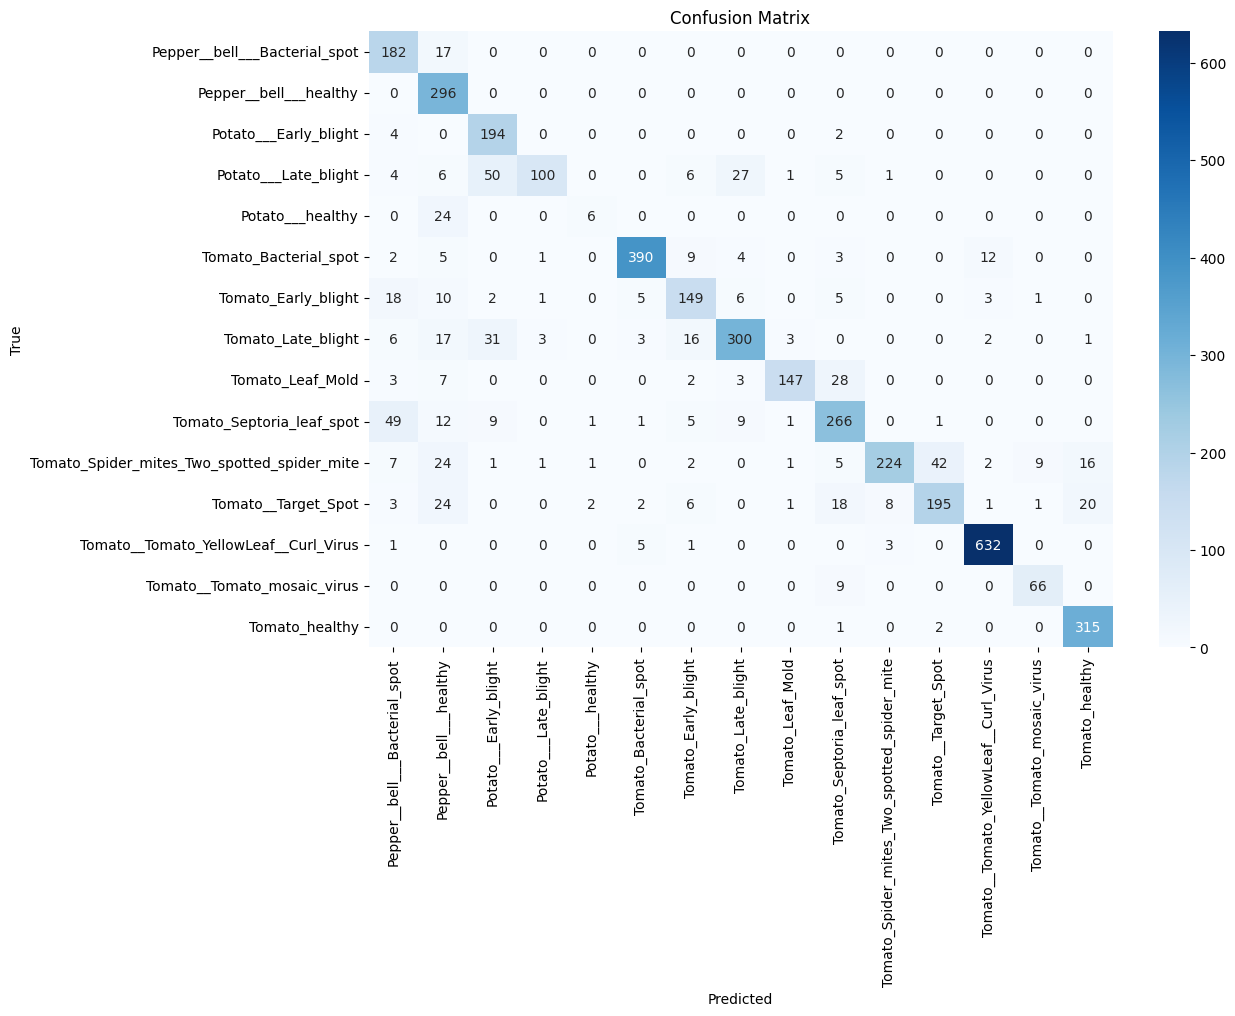

In [17]:
# Menghitung confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [18]:
# Menyimpan model
model.save('PlantDiseaseModel.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Conclution

Berdasarkan hasil evaluasi, model yang dikembangkan mampu mengidentifikasi penyakit pada daun tanaman dengan akurasi yang baik.
Model ini dapat digunakan untuk membantu petani dalam mendeteksi penyakit tanaman secara cepat dan akurat, sehingga dapat meningkatkan hasil panen.

## Prediction

In [19]:
import tensorflow as tf

# Load the saved model
model = tf.keras.models.load_model('PlantDiseaseModel.h5')

In [20]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Upload a new image
uploaded = files.upload()

# Function to load and preprocess the image
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(128, 128))
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

KeyboardInterrupt: 

In [ ]:
# Function to make prediction
def predict_image(img_path):
    processed_img = load_and_preprocess_image(img_path)
    prediction = model.predict(processed_img)
    predicted_class_index = np.argmax(prediction, axis=1)
    class_labels = list(train_generator.class_indices.keys())
    predicted_class_label = class_labels[predicted_class_index[0]]
    return predicted_class_label

In [ ]:
# Function to display the prediction result
def display_prediction(img_path, predicted_class):
    img = image.load_img(img_path, target_size=(128, 128))
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class}")
    plt.axis('off')
    plt.show()

In [ ]:
# Process the uploaded image and predict
for img_name in uploaded.keys():
    predicted_class_label = predict_image(img_name)
    print(f"Predicted class: {predicted_class_label}")
    display_prediction(img_name, predicted_class_label)